Title: Les séries temporelles avec Python (2/4)
Author: Louis
Date: '2021-05-25'
Slug: timeseries-2
Category: Python
Tags: Python, Machine Learning, Statistiques, Data Science, Séries temporelles, Datetime
Cover: images/cover_4.png
Summary: Introduction à la manipulation de données temporelles avec Python

# Les séries temporelles avec Python (2/4)

>1. Introduction à la manipulation de données temporelles avec Python
>2. **Visualisation et opérations sur les séries temporelles**
>3. Éléments théoriques et exemples
>4. Analyse, modélisation et prédiction

On continue dans la série des séries temporelles avec un second article qui s'intéresse à la visualisation et aux opérations que l'ont peut effectuer sur les objets séries temporelles avant de conclure sur un petit exemple en utilisant les outils présentés dans ces 2 premiers posts.

# Visualisation et opérations sur les séries temporelles

## Un peu d'anglicisme : Resampling, Shifting, and Windowing

- *Resampling* = rééchantillonnage
- *Shifting* = déplacement
- *Windowing* = fenêtrage

La capacité à utiliser les dates/times comme indices pour organiser et accéder aux données est une point important des outils de séries temporelles sur Pandas. Les avantages de l'indexation (alignement, slicing, etc...) sont conservés et Pandas fournit par ailleurs plusieurs opérations spécifiques aux séries temporelles. Petite reprécision, le terme "séries temporelles" désigne en général, dans le contexte `Pandas`, un objet `Series` indexé par un `DatetimeIndex`,.

On va donc développer ici quelques unes de ces opérations merveilleurses en utilisant comme premier exemple le cours de l'action Google en bourse (données récupérées sur [Yahoo finance](https://fr.finance.yahoo.com/quote/GOOG/history?p=GOOG)).

In [121]:
import pandas as pd
goog = pd.read_csv('data/GOOG.csv', index_col='Date', parse_dates=True)
goog.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,49.813290,51.835709,47.800831,49.982655,49.982655,44871361
2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942874
2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342897


In [2]:
goog.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-20,2328.040039,2360.340088,2321.090088,2356.090088,2356.090088,1191600
2021-05-21,2365.989990,2369.000000,2342.370117,2345.100098,2345.100098,1139600
2021-05-24,2367.000000,2418.479980,2360.110107,2406.669922,2406.669922,1061400


Ces données recensent donc un certain nombre d'information sur l'action Google du 19 août 2004 au 24 mai 2021 : les prix à l'ouverture et à la clôture, le maximum et le minimum sur la journée, les prix ajustés et les volumes. On va s'intéresser  à la série temporelle des prix à la clôture.

In [3]:
goog = goog['Close']
goog.index

DatetimeIndex(['2004-08-19', '2004-08-20', '2004-08-23', '2004-08-24',
               '2004-08-25', '2004-08-26', '2004-08-27', '2004-08-30',
               '2004-08-31', '2004-09-01',
               ...
               '2021-05-11', '2021-05-12', '2021-05-13', '2021-05-14',
               '2021-05-17', '2021-05-18', '2021-05-19', '2021-05-20',
               '2021-05-21', '2021-05-24'],
              dtype='datetime64[ns]', name='Date', length=4220, freq=None)

C'est bien une série temporelle indexée par un `DatetimeIndex` que l'on affiche élégamment en fixant les paramètres d'affichage par défaut comme étant ceux de `seaborn`.

**Petite astuce au passage :** Les paramètres d'affichage par défaut de `matplotlib` sont stockés dans un fichier spécifique à cette librairie, [un fichier rc](https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-matplotlibrc-files). On peut changer de manière dynamique les réglages rc par défaut en utilisant la variable `matplotlib.rcParams` qui stocke les différents paramètres du fichier rc sous forme de dictionnaire. On peut donc par exemple fixer la taille par défaut des graphiques comme ci-dessous. Avec cette méthode, les paramètres seront actifs pour votre script ou votre notebook mais ça ne modifie pas pour autant le fichier rc ! Pour en savoir plus sur la customisation de matplotlib, qui est tout à fait hors sujet dans cet article, c'est [par ici](https://matplotlib.org/stable/tutorials/introductory/customizing.html).

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set() #pour définir les paramètres d'affichage de seaborn par défaut
plt.rcParams["figure.figsize"] = (12,8)

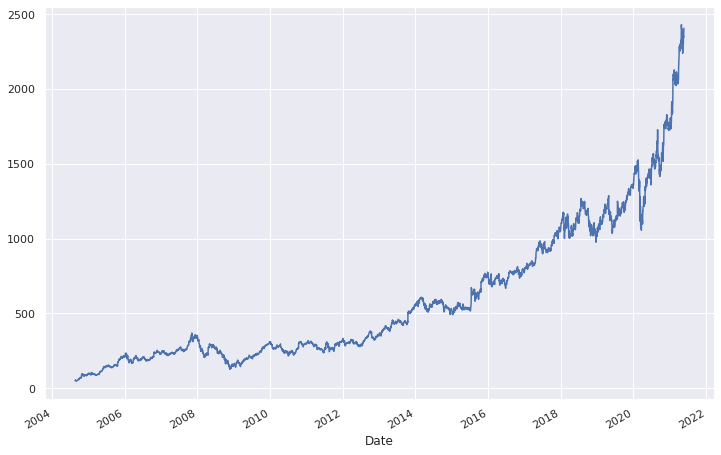

In [9]:
goog.plot();

### Rééchantillonage et conversion de fréquences

Une manipulation classique des séries temporelles est le rééchantionnage (resampling) à une fréquence plus ou moins haute. Cela consiste à augmenter ou diminuer la fréquence des observations. Il y a donc 2 possibilités : 
- si on augmente la fréquence cela veut dire ajouter des points et dans ce cas il faut définir quelle stratégie utiliser pour interpoler les nouveaux points (un exemple de stratégie basique est de répéter la dernière valeur)
- si on diminue la fréquence, ce qui est le cas le plus classique, on va supprimer des points et il faut là aussi déterminer la stratégie à utiliser. Deux options sont possibles : on sélectionne uniquement les points correspondants à la nouvelle fréquence plus faible ou bien on agrège les points entre 2 fréquences en utilisant une fonction d'aggrégation comme par exemple une moyenne, une médiane, un max, etc...

Pour ce faire, `pandas` dispose de deux méthodes qui sont `resample()` ou `asfreq()`. La différence entre les deux est que `resample` consiste à agréger toutes les données comprises entre 2 multiples de la fréquence alors que `asfreq` sélectionne la valeur correspondant à la fréquence. Aussi, `resample` renvoie un objet particulier qui est un `DatetimeIndexResampler` sur lequel il faut appliquer une méthode d'aggrégation ou d'imputation pour récupérer une série. La méthode `asfreq` retourne directement une série.

On va de ce pas illustrer avec la série Google en diminuant la fréquence afin de n'avoir qu'un point par année. On va prendre le dernier jour ouvrable de l'année (jour ouvrable car la série prend des valeurs uniquement pour les jours ouvrables).

Petit rappel, on utilise ci-dessous, le code de fréquence `BA` pour récupérer le dernier jour ouvrable de l'année mais pour en savoir plus sur les fréquences, [l'épisode 1 de cette série](https://blog.statoscop.fr/timeseries-1.html) vous en apprendra davantage.

In [15]:
goog.resample('BA')

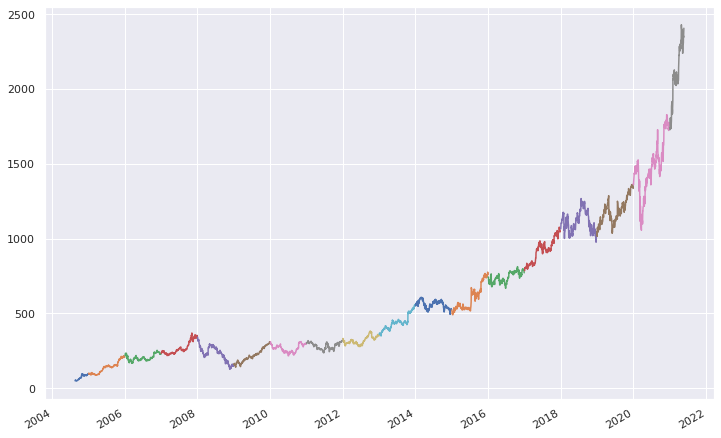

In [18]:
goog.resample('BA').plot();
# la coloration permet de voir quelles valeurs seront agrégées, ici, annuelles

In [16]:
goog.asfreq('BA')

Date
2004-12-31      96.035034
2005-12-30     206.655411
2006-12-29     229.380234
2007-12-31     344.448914
2008-12-31     153.250580
2009-12-31     308.832428
2010-12-31     295.875977
2011-12-30     321.744019
2012-12-31     352.369232
2013-12-31     558.262512
2014-12-31     524.958740
2015-12-31     758.880005
2016-12-30     771.820007
2017-12-29    1046.400024
2018-12-31    1035.609985
2019-12-31    1337.020020
2020-12-31    1751.880005
Freq: BA-DEC, Name: Close, dtype: float64

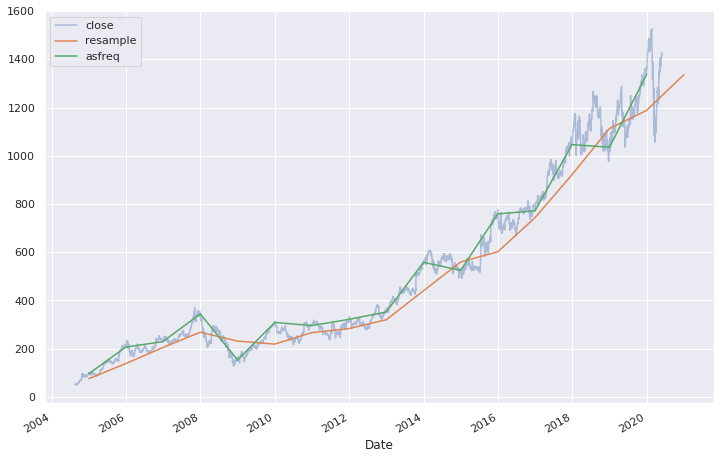

In [36]:
goog.plot(alpha=0.4)
goog.resample('BA').mean().plot()
goog.asfreq('BA').plot();
plt.legend(['close', 'resample', 'asfreq'], loc='upper left');

Pour un resampling avec une fréquence plus importante, `resample()` et `asfreq()` sont équivalentes. Par défaut, les 2 méthodes laissent les valeurs non existantes vides. Toutefois, `asfreq()` accepte un paramètre `method` dans lequel on peut spécifier comment imputer les valeurs manquantes générées par l'augmentation de la fréquence. C'est faisable aussi avec `resample` en utilisant les méthodes `bfill` ou `ffill` des objets `pandas.core.resample.Resampler`.

Dans la cellule de code ci-dessous on selectionne uniquement les 14 derniers jours et on fait un resampling de la série avec une fréquence quotidienne (cela inclue donc les weekends !). Ensuite on affiche pour chaque méthode (`resample()` et `asfreq()`) les courbes rééchatillonnées sans imputer les valeurs manquantes, avec une imputation de type `bfill` qui impute la première valeur qui suit (donc dans ce cas la valeur du lundi) et de type `ffill` qui impute la dernière valeur (donc ici, celle du vendredi).

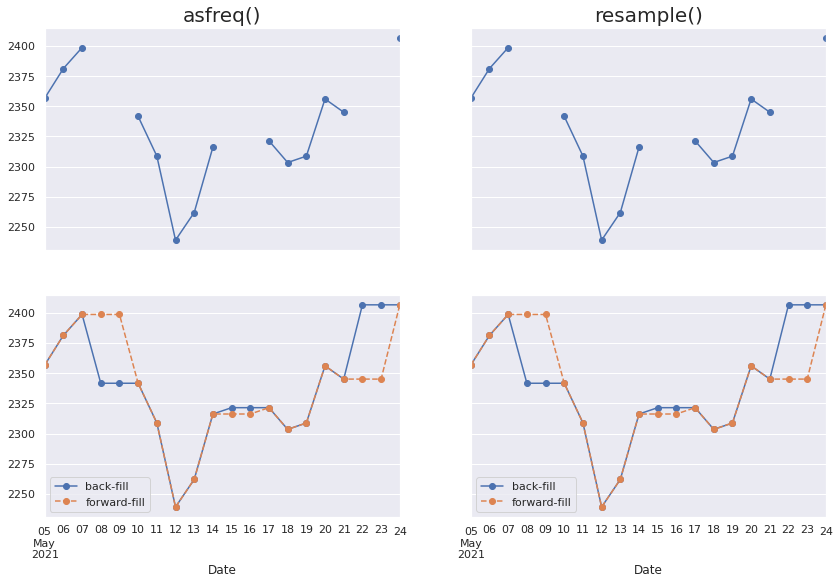

In [10]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(14,9))
data = goog.iloc[-14:]

#avec asfreq
data.asfreq('D').plot(ax=ax[0,0], marker='o')
ax[0,0].set_title("asfreq()", fontsize=20);

data.asfreq('D', method='bfill').plot(ax=ax[1,0], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1,0], style='--o')
ax[1,0].legend(["back-fill", "forward-fill"]);

#avec resample
data.resample('D').mean().plot(ax=ax[0,1], marker='o')
ax[0,1].set_title("resample()", fontsize=20);

data.resample('D').bfill().plot(ax=ax[1,1], style='-o')
data.resample('D').ffill().plot(ax=ax[1,1], style='--o')
ax[1,1].legend(["back-fill", "forward-fill"]);

### Déplacements

Une autre opération classique sur les séries temporelles est le déplacement ou décalage (on parle plus souvent de *time-shifts* ou *shifting*)

On utilise pour cette opération la méthode `shift()`. Il exisste une autre méthode `tshift()` qui est maintenant dépréciée et sera supprimée des prochains versions. Pour faire court, la différence entre les deux était que `shift()` déplace les données alors que`tshift()` déplace les index. Dans les 2 cas, le décalage doit être un multiple de la fréquence !

<ipython-input-20-bfecad5ee2c1>:7: FutureWarning: tshift is deprecated and will be removed in a future version. Please use shift instead.
  goog.tshift(900).plot(ax=ax[2])


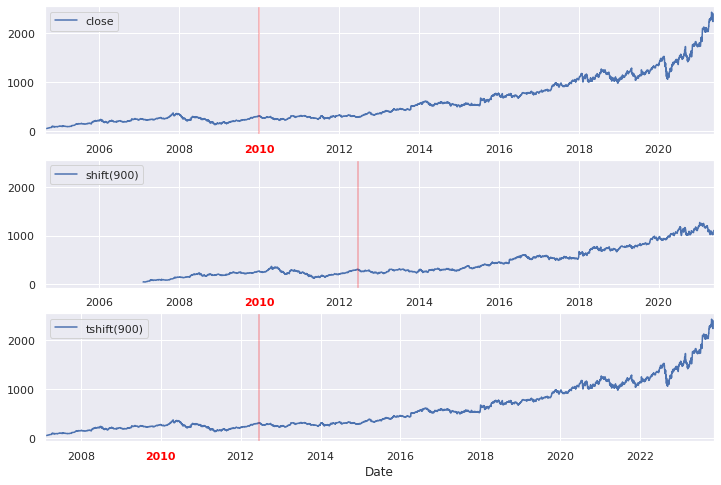

In [20]:
fig, ax = plt.subplots(3, sharey=True)

goog = goog.asfreq('D', method='ffill')

goog.plot(ax=ax[0])
goog.shift(900).plot(ax=ax[1])
goog.tshift(900).plot(ax=ax[2])

local_max = pd.to_datetime('2010-01-01')
offset = pd.Timedelta(900, 'D')

ax[0].legend(['close'], loc=2)
ax[0].get_xticklabels()[3].set(weight='heavy', color='red')
ax[0].axvline(local_max, alpha=0.3, color='red')

ax[1].legend(['shift(900)'], loc=2)
ax[1].get_xticklabels()[3].set(weight='heavy', color='red')
ax[1].axvline(local_max + offset, alpha=0.3, color='red')

ax[2].legend(['tshift(900)'], loc=2)
ax[2].get_xticklabels()[2].set(weight='heavy', color='red')
ax[2].axvline(local_max + offset, alpha=0.3, color='red');

Une utilisation possible du *shifting* est par exemple de calculer le retour sur investissement à 1 an de l'action de Google (ROI - *return on investment*, par ici [Wiki](https://en.wikipedia.org/wiki/Return_on_investment)). Qu'en conclure ? Pour les boursicoteurs, vous avez raté le coche, fallait acheter en 2004 ou en 2009.

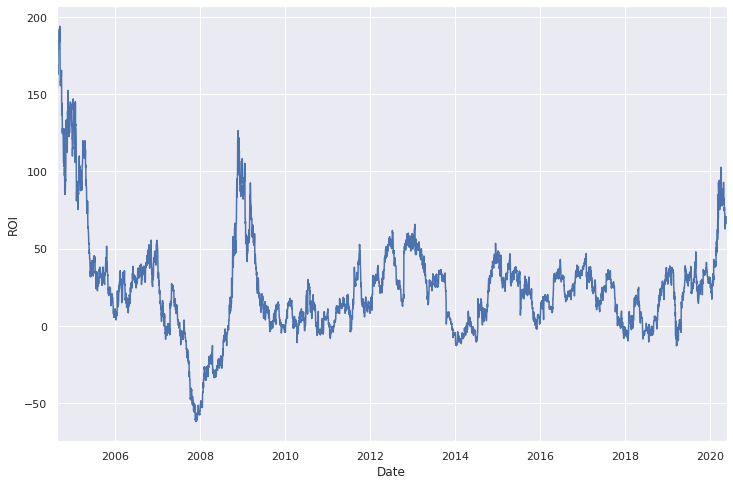

In [62]:
ROI_1 = 100 * (goog.shift(-365) / goog - 1)
ROI_1.iloc[:-365].plot()
plt.ylabel('ROI');

### Attention, fenêtres glissantes

Enfin, la 3ème opération classique des séries temporelles consiste à calculer différentes statistiques sur une fenêtre d'une longueur donnée et qui se déplace. On parle plus de *rolling window* et que de fenêtres glissantes...et pour ce faire, Pandas a tout ce qu'il faut avec la méthode `rolling()` pour les objets `Series` et `DataFrame`. Pour illustrer, on va calculer avec la méthode rolling la moyenne annuelle centrée et l'écart-type annuel centré avant bien sûr de les afficher.

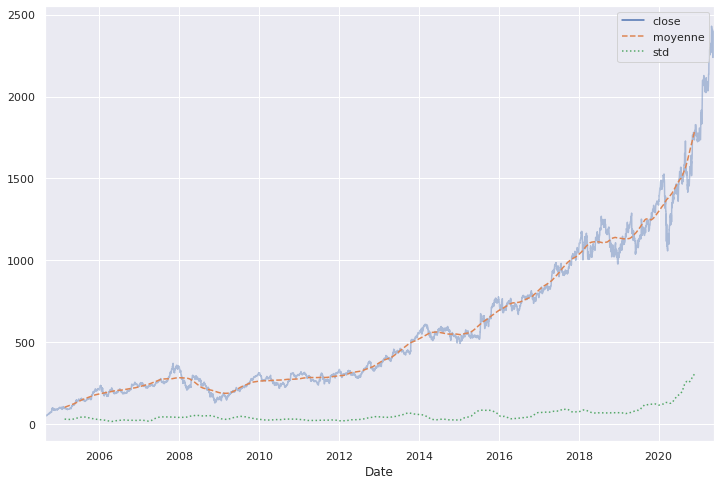

In [63]:
rol = goog.rolling(365, center=True)

data = pd.DataFrame({'close': goog,
                     'moyenne': rol.mean(),
                     'std': rol.std()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.4)

## Un exemple de visualisation : le nombre de vélos à Paris Montparnasse

On va terminer sur un petit exemple un peu plus parlant, ou en tout cas, un peu moins financier : on va regarder le nombre de vélo passés par un des compteurs de la ville de Paris, situé sur le boulevard Montparnasse. Le jeu de données vient [de là](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name). Le décompte horaire des vélos peut ainsi être récupéré.

In [78]:
velo = pd.read_csv('data/comptage-velo-donnees-compteurs.csv', sep=';')
velo.head(3)

,Identifiant du compteur,Nom du compteur,Identifiant du site de comptage,Nom du site de comptage,Comptage horaire,Date et heure de comptage,Date d'installation du site de comptage,Lien vers photo du site de comptage,Coordonnées géographiques
0,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,21.0,2020-04-01T07:00:00+02:00,2018-12-07,https://www.eco-visio.net/Photos/100049407/154...,"48.840801,2.333233"
1,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,21.0,2020-04-01T09:00:00+02:00,2018-12-07,https://www.eco-visio.net/Photos/100049407/154...,"48.840801,2.333233"
2,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,14.0,2020-04-01T12:00:00+02:00,2018-12-07,https://www.eco-visio.net/Photos/100049407/154...,"48.840801,2.333233"


Beaucoup de colonnes inutiles dans ces données donc on va se contenter de ce qui nous intéresse : le timestamp et le nombre de vélos. Avec un petit peu de nettoyage directement au moment de l'import, ça donne :

In [112]:
velo = pd.read_csv('data/comptage-velo-donnees-compteurs.csv', sep=';',
                   names=["nb", "date"], header=0,
                   usecols=[4,5])
velo.head(3)

,nb,date
0,21.0,2020-04-01T07:00:00+02:00
1,21.0,2020-04-01T09:00:00+02:00
2,14.0,2020-04-01T12:00:00+02:00


En important le jeu de données, on voit ce "+02:00" qui définit en fait la timezone. Plusieurs solutions possibles pour gérer ce problème :
- on peut utiliser les méthodes de manipulation de timezone avec `tz_convert` et `tz_localize`
- on peut définir notre propre parser de date au moment de l'import en supprimant le "+02:00" avec un `split` par exemple.

Ci-dessous, ces 2 approches mises en oeuvre.

In [113]:
pd.DatetimeIndex(pd.to_datetime(velo.date, utc=True)).tz_convert('Europe/Paris').tz_localize(None)

DatetimeIndex(['2020-04-01 07:00:00', '2020-04-01 09:00:00',
               '2020-04-01 12:00:00', '2020-04-01 15:00:00',
               '2020-04-01 16:00:00', '2020-04-01 19:00:00',
               '2020-04-01 20:00:00', '2020-04-01 21:00:00',
               '2020-04-01 22:00:00', '2020-04-01 23:00:00',
               ...
               '2021-05-22 20:00:00', '2021-05-23 00:00:00',
               '2021-05-23 02:00:00', '2021-05-23 03:00:00',
               '2021-05-23 04:00:00', '2021-05-23 16:00:00',
               '2021-05-23 19:00:00', '2021-05-24 02:00:00',
               '2021-05-24 05:00:00', '2021-05-24 14:00:00'],
              dtype='datetime64[ns]', name='date', length=10046, freq=None)

In [123]:
velo = pd.read_csv('data/comptage-velo-donnees-compteurs.csv', sep=';',
                   names=["nb", "date"], header=0,
                   usecols=[4,5],
                   index_col="date",
                   parse_dates=True,
                   date_parser=lambda s: pd.to_datetime(s.split("+")[0])
                  )
# read_csv retourne un dataframe or on veut un objet Series, donc puisqu'on le veut, et qu'on l'a, ben on le prend.
velo = velo.nb
velo[:3]

date
2020-04-01 07:00:00    21.0
2020-04-01 09:00:00    21.0
2020-04-01 12:00:00    14.0
Name: nb, dtype: float64

In [124]:
velo.index

DatetimeIndex(['2020-04-01 07:00:00', '2020-04-01 09:00:00',
               '2020-04-01 12:00:00', '2020-04-01 15:00:00',
               '2020-04-01 16:00:00', '2020-04-01 19:00:00',
               '2020-04-01 20:00:00', '2020-04-01 21:00:00',
               '2020-04-01 22:00:00', '2020-04-01 23:00:00',
               ...
               '2021-05-22 20:00:00', '2021-05-23 00:00:00',
               '2021-05-23 02:00:00', '2021-05-23 03:00:00',
               '2021-05-23 04:00:00', '2021-05-23 16:00:00',
               '2021-05-23 19:00:00', '2021-05-24 02:00:00',
               '2021-05-24 05:00:00', '2021-05-24 14:00:00'],
              dtype='datetime64[ns]', name='date', length=10046, freq=None)

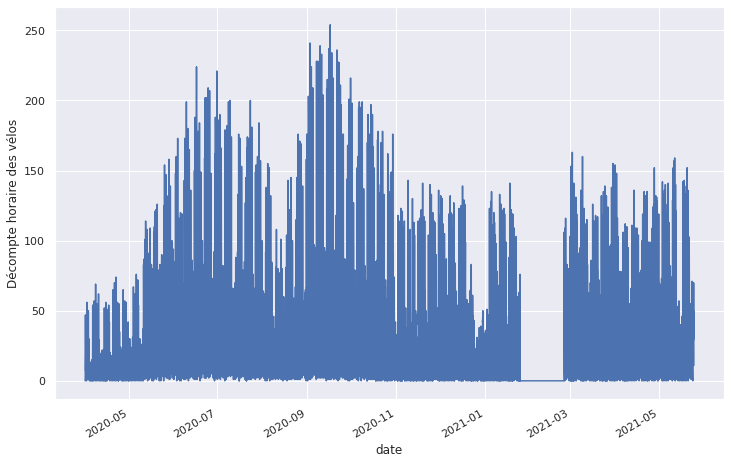

In [125]:
velo.plot(legend=False)
plt.ylabel('Décompte horaire des vélos');

On voit pas grand chose pour le moment mais on détecte déjà un problème de valeurs manquantes au mois de février 2021. On va donc prendre les données de 2020 uniquement pour s'épargner la gestion de ces manquants.

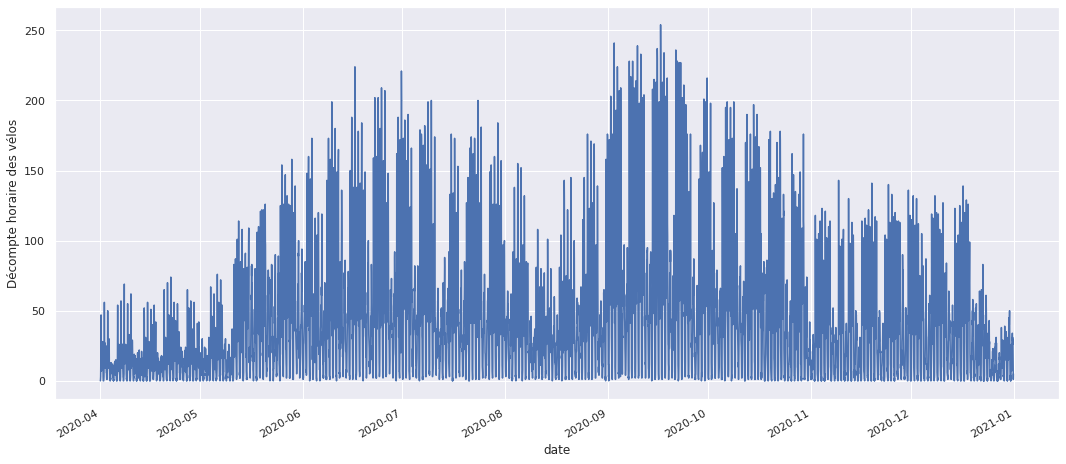

In [135]:
velo = velo['2020']
velo.plot(legend=False, figsize=(18,8))
plt.ylabel('Décompte horaire des vélos');

On regarde quelques statistiques descriptives de cette série avec la méthode `describe` :

In [136]:
velo.describe()

count    6597.000000
mean       39.788692
std        41.729353
min         0.000000
25%         7.000000
50%        29.000000
75%        57.000000
max       254.000000
Name: nb, dtype: float64

La série par heure étant trop "dense" pour être clairement lisible, on va diminuer la fréquence avec un `resample` pour faire la somme des vélos sur une journée et sur une semaine.

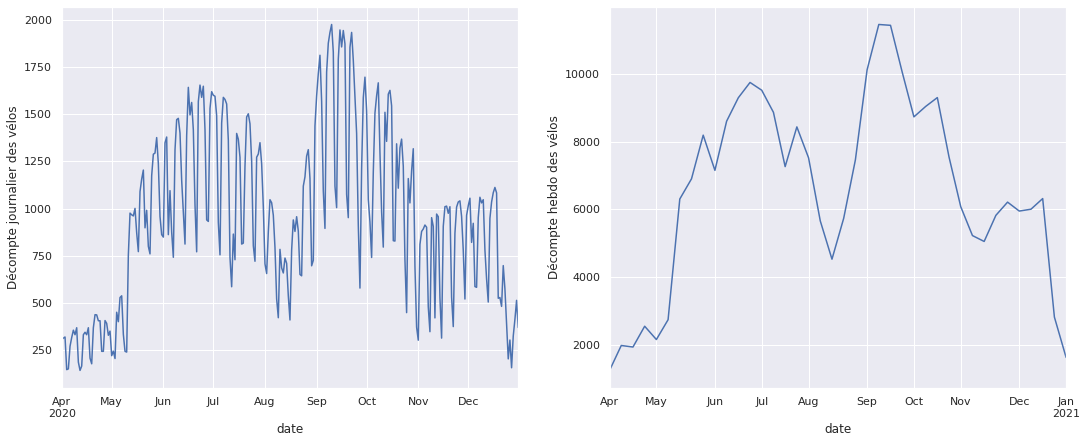

In [138]:
fig, ax = plt.subplots(1,2,figsize=(18,7))

velo_jr =  velo.resample('D').sum()
velo_jr.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Décompte journalier des vélos');

velo_sem =  velo.resample('W').sum()
velo_sem.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Décompte hebdo des vélos');

Avec ces rééchantillonages on veut une tendance annuelle qui se dégage avec notamment un pic de reprise d'activité au printemps, après le confinement et une baisse de fréquentation pendant l'été. De la même manière, la baisse significative visible au mois de novembre est certainement dûe ausecond confinement de 2020.

Une autre information visible sur le graphique des décomptes journaliers est la baisse du nombre de vélo environ 4 fois par mois, cela correspond certainement aux weekends mais ne nous avançons pas trop...

On va regarder avec méthode `rolling`, la moyenne mobile mensuelle et faire jouer certains paramètres afin de voir ce qu'il en est.

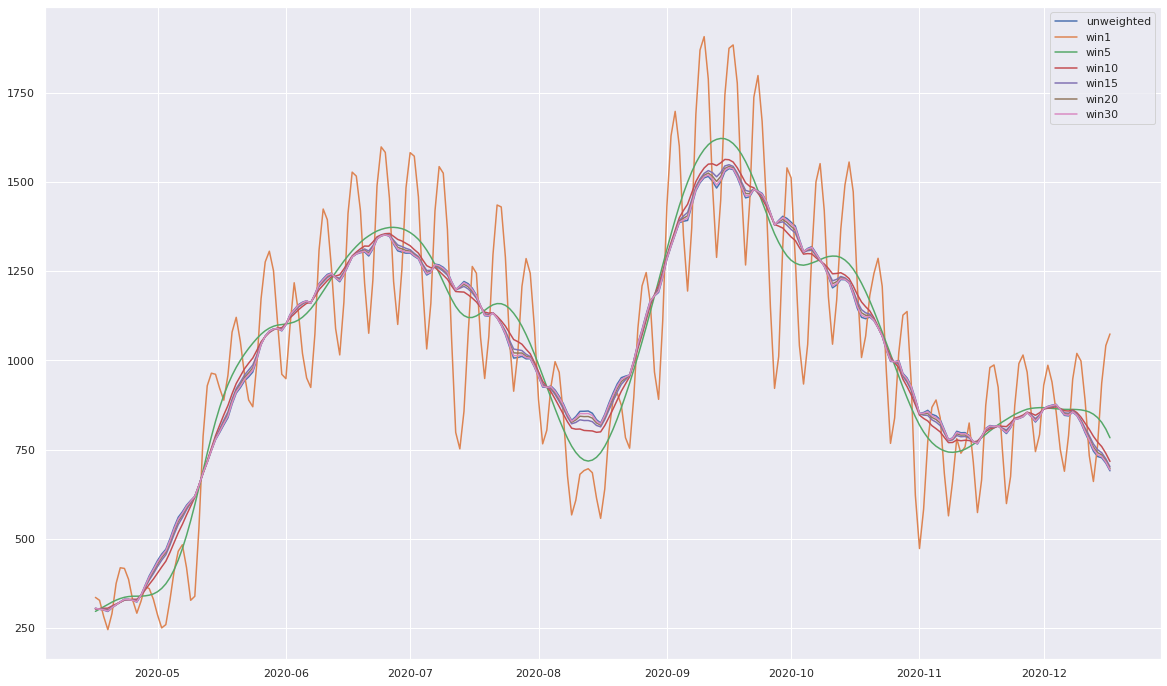

In [142]:
plt.figure(figsize=(20,12))
plt.plot(velo_jr.rolling(30, center=True).mean(),label="unweighted")

for std in [1,5,10,15,20,30]:
    plt.plot(velo_jr.rolling(30, center=True, win_type='gaussian').mean(std=std), label=f"win{std}")

plt.legend(loc='best');

Le paramètre `win_type="gaussian"` permet d'appliquer une pondération au calcul de la moyenne. En l'occurence on applique des poids qui suivent une loi normale dont l'écart-type est défini dans la fonction d'aggrégation`mean`. Plus cet écart type est faible, plus les jours proches comptent et ceux éloignés ne comptent pas. C'est le cas de la courbe orange qui a donc tendance à suivre d'assez près la courbe initiale. En revanche, si l'on augmente l'écart-type, on prend en compte plus de jours autour et on lisse ainsi les résultats. Pour finir, si l'écart-type est très élevé, alors on pondère de manière quasi identique les 30 jours de la fenêtre et on retombe donc sur une moyenne non-pondérée.

On va regarder maintenant comment ça se passe au niveau hebdomadaire pour comprendre comment évolue la fréquentation selon les différents horaires d'une journée et selon les différents jours d'une semaine. Pour cela, on va pouvoir utiliser les attributs `time` et `dayofweek` des objets `DatetimeIndex` afin d'afficher les décomptes de vélos par heure de la journée et par jour de la semaine.

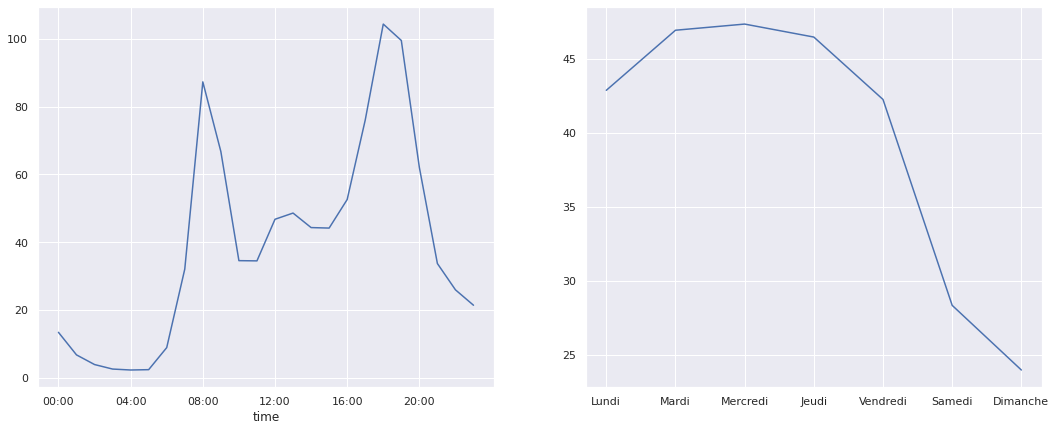

In [144]:
import numpy as np
fig, ax = plt.subplots(1,2,figsize=(18,7))

par_hr = velo.groupby(velo.index.time).mean()
heures = 4 * 60 * 60 * np.arange(6)
par_hr.plot(ax=ax[0], xticks=heures, legend=False);

par_sem = velo.groupby(velo.index.dayofweek).mean()
par_sem.index = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
par_sem.plot(ax=ax[1], legend=False);

On retrouve bien certaines informations qu'on avait évoquées :
- baisse de la fréquentation le weekend et sur une journée,
- pics de fréquentation à 8h et à 18h et légère augmentation à l'heure du déjeuner.

Cette 2ème information est certes logique pour les jours ouvrables mais c'est étonnant pour les jours de weekends...allons voir de plus près !

In [149]:
jours_ouvrables = np.where(velo.index.dayofweek < 5, 'Ouvrable', 'Weekend')
par_hr = velo.groupby([jours_ouvrables, velo.index.time]).mean()

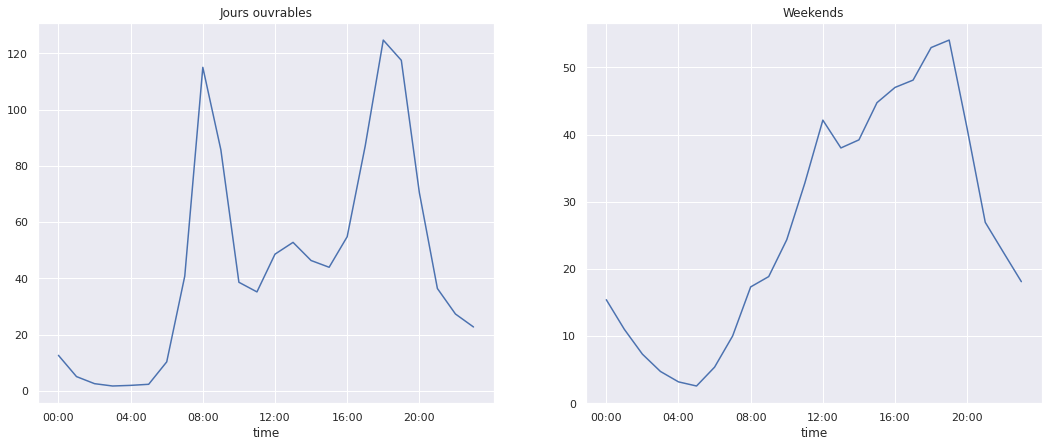

In [150]:
fig, ax = plt.subplots(1,2,figsize=(18,7))
par_hr.loc['Ouvrable'].plot(ax=ax[0], title='Jours ouvrables', xticks=heures, legend=False)
par_hr.loc['Weekend'].plot(ax=ax[1], title='Weekends', xticks=heures, legend=False);

C'est tout de suite plus clair : les gens dorment et sortent se promener le weekend ! Nous voilà rassurés. Sur cette belle découverte, on se dit à très vite pour le poste numéro 3 de cette série !